In [74]:
import cantera as ct
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Video
from IPython.display import HTML
from pathlib import Path

In [75]:
# parameter values
p0 = 101325  # pressure
T0 = 296  # inlet temperature
phi = 0.7 # equivalence ratio
alpha = 0.566 # volume fraction(<1)

#mdot(=mass flux, 단위 면적당 시간당 전달되는 질량)
mdot_reactants = 80  # kg/m^2/s # 반응물이 1초당 1m² 면적을 통해 80kg 만큼 들어온다
mdot_products = mdot_reactants  # kg/m^2/s #생성물이 반응 후에 같은 속도로 배출된다, mass conservation

# Mechanism and fuel composition
xh2 = alpha / (1 - alpha) * 1  # xh2 = alpha/(1-alpha)*xc
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

# Calculation params
width = 0.1  # m domain width
loglevel = 0  # amount of diagnostic output (0 to 5)

In [76]:
# Gas object 1 for the counterflow flame
gas1=ct.Solution('gri30.yaml') # reaction mechanism file
gas1.TP = T0, p0

#fix the composition of the fuel
gas1.set_equivalence_ratio(phi, fuel, oxidizer)  # hold temperature and pressure constant 

# Create the counterflow premixed flame simulation object
fl1 = ct.CounterflowPremixedFlame(gas=gas1, width=width)
fl1.transport_model = 'multicomponent'
fl1.energy_enabled = True #energy equation
fl1.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# set the boundary flow rates
fl1.reactants.mdot = mdot_reactants
fl1.products.mdot = mdot_products

fl1.set_initial_guess()  # assume adiabatic equilibrium products
fl1.solve(loglevel, auto=True)
print(fl1.products.T)

1882.0048963720276


In [77]:
# Gas object 2 for the counterflow flame with non equilibrium products
gas2=ct.Solution('gri30.yaml')
gas2.TP = T0, p0
gas2.set_equivalence_ratio(phi, fuel, oxidizer)

# Create the flame simulation object
fl2 = ct.CounterflowPremixedFlame(gas=gas2, width=width)
# Set grid refinement parameters
fl2.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# set the boundary flow rates
fl2.reactants.mdot = mdot_reactants
fl2.products.mdot = mdot_products

#product temperature, temperature of my project
fl2.products.T =2000
fl2.products.X =fl1.products.X #composition of the products

fl2.set_initial_guess(equilibrate=False)
fl2.solve(loglevel, auto=True)
print(fl2.products.T)

2000.0


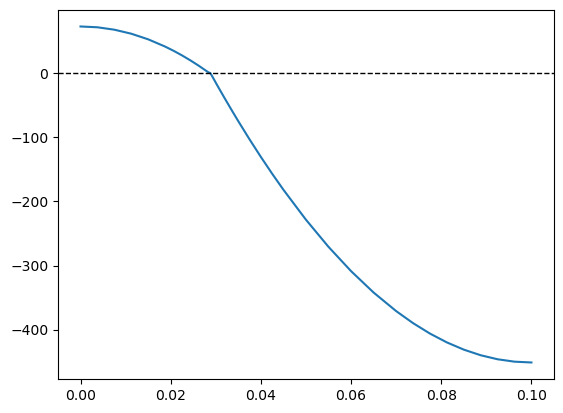

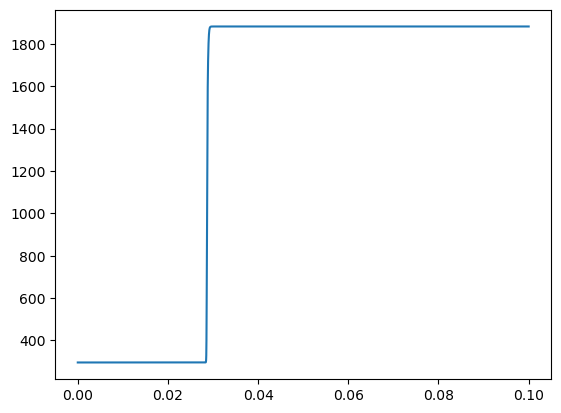

In [78]:
plt.figure()
plt.plot(fl1.grid,fl1.velocity)
plt.axhline(y=0, color='k', linestyle='--',linewidth=1) #stagnation line
#plt.show()

plt.figure()
plt.plot(fl1.grid,fl1.T)
#plt.show()

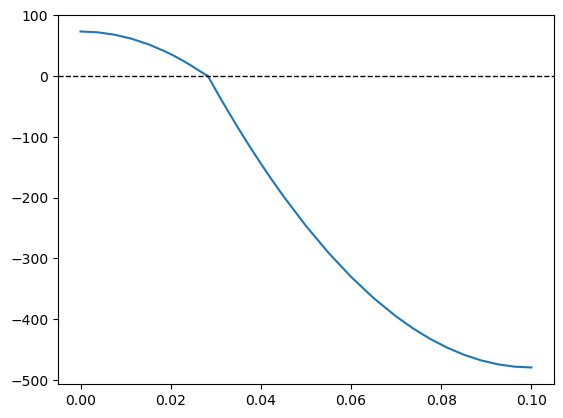

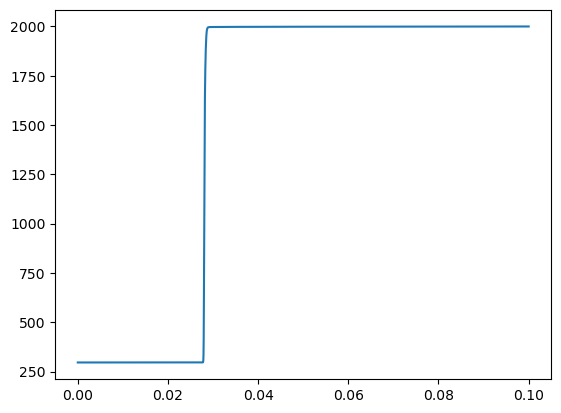

In [79]:
plt.figure()
plt.plot(fl2.grid,fl2.velocity)
plt.axhline(y=0, color='k', linestyle='--',linewidth=1) #stagnation line
#plt.show()

plt.figure()
plt.plot(fl2.grid,fl2.T)
#plt.show()

In [85]:
def calculate_consumption_speed(flame, species):
    """
    function that calculate consumption speed about the flame and species
    
    Parameters:
    flame (ct.CounterflowPremixedFlame): flame object
    species (str): species that calculate consumption speed(ex: 'CH4')
    
    Returns:
    float: consumption speed (m/s)
    """
    omega_f = flame.net_production_rates  # 화학 반응 속도 (모든 종에 대해)
    rho_u = flame.density[0]  # 반응물 밀도
    Y_f_u = flame.Y[0, flame.gas.species_index(species)]  # reactants mass fraction

    # select react speed about the certain species
    omega_f_species = omega_f[flame.gas.species_index(species), :]  # (grid size,) 형태로 가져옴

    # distance difference in grid
    dx = np.diff(flame.grid)  # (크기: n_grid_points-1)

    # using omega_f average between two grids to integrate
    omega_avg = 0.5 * (omega_f_species[:-1] + omega_f_species[1:])  # avg btn grids

    # integrate
    integral_omega_f = np.sum(omega_avg * dx)  # 적분

    # Sc calculation
    S_cf = -1 / (rho_u * Y_f_u) * integral_omega_f
    return S_cf

# fl1 consumption speed
Sc_fl1 = calculate_consumption_speed(fl1, 'CH4')
print(f'consumption speed (Sc) for fl1: {Sc_fl1} m/s')

# fl2 consumption speed
Sc_fl2 = calculate_consumption_speed(fl2, 'CH4')
print(f'consumption speed (Sc) for fl2: {Sc_fl2} m/s')


consumption speed (Sc) for fl1: 0.13581276587495672 m/s
consumption speed (Sc) for fl2: 0.1533183922293594 m/s


In [87]:
# set stretch rate and heat loss
stretch_rate = 10.0  # 1/s (ex)
heat_loss_coefficient = 0.1  # W/m^2·K (ex)

# heat loss calculate function regarding to the temperature
def calculate_heat_loss(T, T_env):
    return heat_loss_coefficient * (T - T_env)

# environment temperature
T_env = 300  # K (ex)

# calculate heat loss
for i in range(len(fl1.grid)):
    heat_loss = calculate_heat_loss(fl1.T[i], T_env)
    print(f'point {i}: temperature {fl1.T[i]:.2f} K, heat loss {heat_loss:.2f} W/m^2')

# analyze composition changes
phi_values = np.linspace(0.5, 1.5, 5)
temperatures = []

for phi in phi_values:
    gas1.set_equivalence_ratio(phi, fuel, oxidizer)
    fl1.set_initial_guess()
    fl1.solve(loglevel, auto=True)
    temperatures.append(fl1.products.T)

point 0: temperature 296.00 K, heat loss -0.40 W/m^2
point 1: temperature 296.00 K, heat loss -0.40 W/m^2
point 2: temperature 296.00 K, heat loss -0.40 W/m^2
point 3: temperature 296.00 K, heat loss -0.40 W/m^2
point 4: temperature 296.00 K, heat loss -0.40 W/m^2
point 5: temperature 296.00 K, heat loss -0.40 W/m^2
point 6: temperature 296.00 K, heat loss -0.40 W/m^2
point 7: temperature 296.00 K, heat loss -0.40 W/m^2
point 8: temperature 296.00 K, heat loss -0.40 W/m^2
point 9: temperature 296.00 K, heat loss -0.40 W/m^2
point 10: temperature 296.00 K, heat loss -0.40 W/m^2
point 11: temperature 296.00 K, heat loss -0.40 W/m^2
point 12: temperature 296.00 K, heat loss -0.40 W/m^2
point 13: temperature 296.00 K, heat loss -0.40 W/m^2
point 14: temperature 296.00 K, heat loss -0.40 W/m^2
point 15: temperature 296.00 K, heat loss -0.40 W/m^2
point 16: temperature 296.00 K, heat loss -0.40 W/m^2
point 17: temperature 296.00 K, heat loss -0.40 W/m^2
point 18: temperature 296.00 K, heat l